- http://keunwoochoi.blogspot.com/2016/03/2.html
- http://www.rex-ai.info/docs/AI_Example_CNN_speech_recognize
- https://www.youtube.com/watch?v=oltGIc4uo5c
- https://youdaeng-com.tistory.com/5
- https://quokkas.tistory.com/37 : early stopping
- https://continuous-development.tistory.com/166 : stratified kfold
- https://deep-learning-study.tistory.com/476 fiter 시각화
- https://wyatt37.tistory.com/10 : random over sampling

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn # 인공 신경망 모델들 모아놓은 모듈
import torch.nn.functional as F #그중 자주 쓰이는것들을 F로
from torchvision import transforms, datasets
import cv2
from torchvision import transforms, datasets
import pandas as pd
import os
from glob import glob
import torchvision.models as models
import sys

p = os.path.abspath('../..') # 상위 폴더를 사용하기 위해서.
sys.path.insert(1, p)
from pytorchtools.pytorchtools import EarlyStopping # 상위 폴더에 추가된 모듈.


if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
#DEVICE = torch.device('cpu')
print('Using Pytorch version : ',torch.__version__,' Device : ',DEVICE)

Using Pytorch version :  1.10.0  Device :  cuda


# SVD 문장 데이터에서 Feature 추출
- mfcc

In [2]:
import numpy as np
import librosa, librosa.display 
import matplotlib.pyplot as plt
#window sizde : FFT를 할때 참조할 그래프 길이 ( 프레임 하나당 sample 수 )
#자연어 처리에서는 25ms 사용. https://ahnjg.tistory.com/93
#초당 50000hz 중 1250개씩 윈도우 사이즈로 사용.
sr=50000
win_length =  np.int64(50000/40) # 1250
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.

In [3]:
import numpy as np
import librosa, librosa.display 
import matplotlib.pyplot as plt
#window sizde : FFT를 할때 참조할 그래프 길이 ( 프레임 하나당 sample 수 )
#자연어 처리에서는 25ms 사용. https://ahnjg.tistory.com/93
#초당 50000hz 중 1250개씩 윈도우 사이즈로 사용.
sr=50000
win_length =  np.int64(50000/40) # 1250
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.

pathology_sig=[]
healthy_sig=[]

pathology=[]
healthy=[]


#PATHOLOGY DATA
for audio_path in os.listdir('../../../voice_data/pathology_new/phrase/export'):
    sig, sr = librosa.load('../../../voice_data/pathology_new/phrase/export/'+audio_path, sr=50000)# 논문에서 f_s = 50 000HZ
    pathology_sig.append(sig)
    mel_feature = librosa.feature.melspectrogram(sig,sr=sr,hop_length=hop_length,n_fft=n_fft)
    mel_feature = librosa.core.power_to_db(mel_feature,ref=np.max)
    pathology.append(mel_feature)
    

#Healthy data
for audio_path in os.listdir('../../../voice_data/healthy_new/phrase/export'):
    sig, sr = librosa.load('../../../voice_data/healthy_new/phrase/export/'+audio_path, sr=50000)# 논문에서 f_s = 50 000HZ
    healthy_sig.append(sig)
    mel_feature = librosa.feature.melspectrogram(sig,sr=sr,hop_length=hop_length,n_fft=n_fft)
    mel_feature = librosa.core.power_to_db(mel_feature,ref=np.max)
    healthy.append(mel_feature)
    
print("pathology data 수 : ",len(pathology))
print("healthy data 수 : ",len(healthy))


path_max=max([ len(samples) for samples in pathology_sig])
healthy_max=max([ len(samples) for samples in healthy_sig])
print("가장 긴 path sample :" ,path_max)
print("가장 긴 healthy sample :" ,healthy_max)

pathology data 수 :  1194
healthy data 수 :  634
가장 긴 path sample : 318596
가장 긴 healthy sample : 207017


In [4]:
print(path_max/sr,"초")
print(healthy_max/sr,"초")

6.37192 초
4.14034 초


# 결과 확인
- 1 row당 1 frame으로

In [5]:
len(healthy[0][2]) #1번 : 파일. 2번:mfcc
#headers = "mfcc1 mfcc2 mfcc3 mfcc4 mfcc5 mfcc6 mfcc7 mfcc8 mfcc9 mfcc10 mfcc11 mfcc12 mfcc13".split()
#pd.DataFrame(healthy[0].T,columns=headers)

print(healthy[0])




[[-40.589996 -39.998337 -38.81555  ... -38.37249  -39.136566 -37.830963]
 [-45.260597 -43.43311  -43.50158  ... -42.478107 -43.67787  -38.517254]
 [-56.9734   -49.211952 -54.667103 ... -49.667316 -53.020805 -38.752518]
 ...
 [-80.       -80.       -80.       ... -80.       -80.       -80.      ]
 [-80.       -80.       -80.       ... -80.       -80.       -80.      ]
 [-80.       -80.       -80.       ... -80.       -80.       -80.      ]]


In [6]:
print(healthy[0].shape) #1번 주파수 축, 2번 시간축.
print(healthy[1].shape)

(128, 326)
(128, 338)


In [7]:
del pathology
del healthy
del pathology_sig
del healthy_sig

# 데이터 나누기 - Stratified KFold

- pathology : 1194 / healthy : 634 / 총 1828
- k = 5

## 1. test/ train 나누기


In [8]:
#1. train, test 나누기

import os
from glob import glob
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from sklearn.model_selection import train_test_split # train , test 분리에 사용.


pathology = glob('../../../voice_data/fusion/pathology/phrase/*.wav')
healthy = glob('../../../voice_data/fusion/healthy/phrase/*.wav')
print("Pathology : ",len(pathology))
print("Healthy: ",len(healthy))

X = pathology+healthy # path 데이터 합
print("총 데이터수 : ",len(X))
Y = [] # 라벨
for idx,x in enumerate(X):
    if idx<1193:
        Y.append("pathology")
    else:
        Y.append("healthy")

X, X_test, Y, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, stratify=Y, random_state=456)
#stratify를 넣어서, test에도 라벨별 잘 분류되게 한다.

print("---")
print("훈련 셋 : ",len(Y),Counter(Y))
print("테스트 셋 : ",len(Y_test),Counter(Y_test))
print("---")

Pathology :  1193
Healthy:  634
총 데이터수 :  1827
---
훈련 셋 :  1461 Counter({'pathology': 954, 'healthy': 507})
테스트 셋 :  366 Counter({'pathology': 239, 'healthy': 127})
---


## 2. stratified k-fold

In [9]:
#1. train, test 나누기
#stratified kfold
import os
import random #데이터 shuffle 사용
from glob import glob
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import RandomOverSampler
from collections import Counter



skf_iris = StratifiedKFold(n_splits=5,shuffle=True,random_state=456)
cnt_iter = 0

X_train_list = [] #데이터 셋 보관
Y_train_list = []

X_valid_list = []
Y_valid_list = []

for train_idx, test_idx in skf_iris.split(X,Y):
    
    #split으로 반환된 인덱스를 이용하여, 학습 검증용 테스트 데이터 추출
    cnt_iter += 1
    X_train, X_valid = [X[idx] for idx in train_idx.tolist() ], [X[idx] for idx in test_idx.tolist() ]
    Y_train, Y_valid = [Y[idx] for idx in train_idx.tolist() ], [Y[idx] for idx in test_idx.tolist() ]
    
    X_train_list.append(X_train)
    X_valid_list.append(X_valid)
    
    Y_train_list.append(Y_train)
    Y_valid_list.append(Y_valid)
    
    
    #학습 및 예측
    
    label_train = Y_train
    label_test = Y_valid
    unique_train, train_counts = np.unique(label_train, return_counts = True)
    unique_test, test_counts = np.unique(label_test, return_counts = True)
    
    uniq_cnt_train = dict(zip(unique_train, train_counts))
    uniq_cnt_test = dict(zip(unique_test, test_counts))
    
    
    
    print('교차 검증 : {}'.format(cnt_iter))
    print('학습 레이블 데이터 분포 : \n', uniq_cnt_train)
    print('검증 레이블 데이터 분포 : \n', uniq_cnt_test,'\n')



교차 검증 : 1
학습 레이블 데이터 분포 : 
 {'healthy': 405, 'pathology': 763}
검증 레이블 데이터 분포 : 
 {'healthy': 102, 'pathology': 191} 

교차 검증 : 2
학습 레이블 데이터 분포 : 
 {'healthy': 406, 'pathology': 763}
검증 레이블 데이터 분포 : 
 {'healthy': 101, 'pathology': 191} 

교차 검증 : 3
학습 레이블 데이터 분포 : 
 {'healthy': 406, 'pathology': 763}
검증 레이블 데이터 분포 : 
 {'healthy': 101, 'pathology': 191} 

교차 검증 : 4
학습 레이블 데이터 분포 : 
 {'healthy': 406, 'pathology': 763}
검증 레이블 데이터 분포 : 
 {'healthy': 101, 'pathology': 191} 

교차 검증 : 5
학습 레이블 데이터 분포 : 
 {'healthy': 405, 'pathology': 764}
검증 레이블 데이터 분포 : 
 {'healthy': 102, 'pathology': 190} 



## 3. random over sampling

In [10]:
#2. random over sampling
for i in range(5):
    X_temp = np.array(X_train_list[i]).reshape(-1,1)#각 데이터를 다 행으로 넣음. (1194,1)
    #Y = np.array(Y)
    ros = RandomOverSampler(random_state = 123)
    X_res,Y_res = ros.fit_resample(X_temp,Y_train_list[i])
    
    print("\n fold{} ".format(i))
    print('before dataset shape {}'.format(Counter(Y_train_list[i])) )
    print('Resampled dataset shape {}'.format(Counter(Y_res)) )
    
    #원래대로 돌리기
    X_res=X_res.reshape(1, -1)
    X_train_list[i]=X_res[0].tolist()
    Y_train_list[i]=Y_res




 fold0 
before dataset shape Counter({'pathology': 763, 'healthy': 405})
Resampled dataset shape Counter({'pathology': 763, 'healthy': 763})

 fold1 
before dataset shape Counter({'pathology': 763, 'healthy': 406})
Resampled dataset shape Counter({'pathology': 763, 'healthy': 763})

 fold2 
before dataset shape Counter({'pathology': 763, 'healthy': 406})
Resampled dataset shape Counter({'pathology': 763, 'healthy': 763})

 fold3 
before dataset shape Counter({'pathology': 763, 'healthy': 406})
Resampled dataset shape Counter({'pathology': 763, 'healthy': 763})

 fold4 
before dataset shape Counter({'pathology': 764, 'healthy': 405})
Resampled dataset shape Counter({'pathology': 764, 'healthy': 764})


# 데이터 정의
- 추가적으로 데이터의 크기를 맞춰주기 위해 3초로 padding 및 truncate 실시 https://sequencedata.tistory.com/25 FixAudioLength
- 논문에서는 400frame으로 설정.(여기서는 500frame)
- 전처리 방법 결정.


In [11]:
from torch.utils.data import Dataset, DataLoader

classes = ["pathology","healthy"]
sr=50000
win_length =  np.int64(50000/40) # 1250
n_fft= win_length # WINDOWS SIZE중 사용할 길이. WINDOW SIZE가 넘어가면 나머지 것들은 zero padding
hop_length= np.int64( np.ceil(win_length/4) ) #  얼마만큼 시간 주기(sample)를 이동하면서 분석을 할 것인지. 일반적으로 window size의 1/4
#또는 10ms만큼으로 한다고 한다.
#hop_length가 mfcc의 frame수를 결정한다.



class svd_dataset(Dataset):
    def __init__(self,data_path_list,classes,data_num,training,transform=None):
        #클래스에서 사용할 인자를 받아 인스턴스 변수로 저장하는 일을 한다.
        #예를들면, 이미지의 경로 리스트를 저장하는 일을 하게 된다.
        
        #data_num : k 개 데이터 셋 중 어떤것을 쓸지
        #test인지 아닌지.
        
        self.path_list = data_path_list[data_num]
        self.data_num = data_num
        self.training = training
        self.label = svd_dataset.get_label(self.path_list,training,data_num)
        self.classes=classes
        self.transform=transform
        
    
    @classmethod
    def get_label(cls,data_path_list,training,data_num):
        label_list=[]
        
        if training:
            for idx,x in enumerate(data_path_list):
                label_list.append(Y_train_list[data_num][idx])
        else:
            for idx,x in enumerate(data_path_list):
                label_list.append(Y_valid_list[data_num][idx])
        #print(label_list)
        return label_list
    
    def __len__(self):
        return len(self.path_list)
        #데이터 셋의 길이를 정수로 반환한다.     
    
       
    def __getitem__(self, idx):
        """
        1. path를 받아서, 소리에서 mfcc를 추출
        2. mfcc를 300프레임으로 패딩.
        3. resnet에 사용되기 위해 3채널로 복사(rgb 처럼)
        4. 0~1 정규화
        
        """
        kind=self.path_list[idx].split('/')[-2]
        number=self.path_list[idx].split('\\')[-1].split('-')[0]
        path_a="../../../voice_data/fusion/"+kind+"/a\\"+number+"-a_n.wav"
        path_i="../../../voice_data/fusion/"+kind+"/i\\"+number+"-i_n.wav"
        path_u="../../../voice_data/fusion/"+kind+"/u\\"+number+"-u_n.wav"

        sig_phrase, sr = librosa.load(self.path_list[idx], sr=50000)# 논문에서 f_s = 50 000HZ
        sig_a, sr = librosa.load(path_a, sr=50000)# 논문에서 f_s = 50 000HZ
        sig_i, sr = librosa.load(path_i, sr=50000)# 논문에서 f_s = 50 000HZ
        sig_u, sr = librosa.load(path_u, sr=50000)# 논문에서 f_s = 50 000HZ        

        
        stft_phrase = librosa.stft(sig_phrase, win_length=win_length,n_fft=n_fft, hop_length=hop_length)
        stft_a = librosa.stft(sig_a, win_length=win_length,n_fft=n_fft, hop_length=hop_length)
        stft_i = librosa.stft(sig_i, win_length=win_length,n_fft=n_fft, hop_length=hop_length)
        stft_u = librosa.stft(sig_u, win_length=win_length,n_fft=n_fft, hop_length=hop_length)
        #stft 300 FRAME이 되도록 패딩.
        length = 300

        magnitude_phrase = np.abs(stft_phrase)
        magnitude_a = np.abs(stft_a)
        magnitude_i = np.abs(stft_i)
        magnitude_u = np.abs(stft_u)
        
        log_spectrogram_phrase = librosa.amplitude_to_db(magnitude_phrase)
        log_spectrogram_a = librosa.amplitude_to_db(magnitude_a)
        log_spectrogram_i = librosa.amplitude_to_db(magnitude_i)
        log_spectrogram_u = librosa.amplitude_to_db(magnitude_u)
        
        pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))
        log_spectrogram_phrase = pad2d(log_spectrogram_phrase, length)
        log_spectrogram_a = pad2d(log_spectrogram_a, length)
        log_spectrogram_i = pad2d(log_spectrogram_i, length)
        log_spectrogram_u = pad2d(log_spectrogram_u, length)        
        
        
        
        if self.transform:
            #print('transform')
            log_spectrogram_phrase=self.transform(log_spectrogram_phrase).type(torch.float32)# 데이터 타입 변화
            log_spectrogram_a=self.transform(log_spectrogram_a).type(torch.float32)# 데이터 타입 변화
            log_spectrogram_i=self.transform(log_spectrogram_i).type(torch.float32)# 데이터 타입 변화
            log_spectrogram_u=self.transform(log_spectrogram_u).type(torch.float32)# 데이터 타입 변화 
            
            log_spectrogram_phrase=torch.stack([log_spectrogram_phrase,log_spectrogram_phrase,log_spectrogram_phrase])# 3채널로 복사.
            log_spectrogram_a=torch.stack([log_spectrogram_a,log_spectrogram_a,log_spectrogram_a])# 3채널로 복사.
            log_spectrogram_i=torch.stack([log_spectrogram_i,log_spectrogram_i,log_spectrogram_i])# 3채널로 복사.
            log_spectrogram_u=torch.stack([log_spectrogram_u,log_spectrogram_u,log_spectrogram_u])# 3채널로 복사.
            
            log_spectrogram_phrase = log_spectrogram_phrase.squeeze(dim=1)
            log_spectrogram_a = log_spectrogram_a.squeeze(dim=1)
            log_spectrogram_i = log_spectrogram_i.squeeze(dim=1)
            log_spectrogram_u = log_spectrogram_u.squeeze(dim=1)
        else:
            ## 사용안하는 곳##########
            #print("else")
            log_spectrogram = torch.from_numpy(log_spectrogram).type(torch.float32)
            log_spectrogram=log_spectrogram.unsqueeze(0)#cnn 사용위해서 추가
            #MFCCs = MFCCs.permute(2, 0, 1)
        return log_spectrogram_phrase,log_spectrogram_a,log_spectrogram_i,log_spectrogram_u,self.classes.index(self.label[idx])
    

In [12]:
# test set 제작을 위한 class
class svd_test_set(Dataset):
    def __init__(self,data_path_list,classes,transform=None):
        #클래스에서 사용할 인자를 받아 인스턴스 변수로 저장하는 일을 한다.
        #예를들면, 이미지의 경로 리스트를 저장하는 일을 하게 된다.
        
        #data_num : k 개 데이터 셋 중 어떤것을 쓸지
        #test인지 아닌지.
        
        self.path_list = data_path_list
        self.label = svd_test_set.get_label(self.path_list)
        self.classes=classes
        self.transform=transform
        
    
    @classmethod
    def get_label(cls,data_path_list):
        label_list=[]
        
        for idx,x in enumerate(data_path_list):
            label_list.append(Y_test[idx])
        #print(label_list)
        return label_list
    
    def __len__(self):
        return len(self.path_list)
        #데이터 셋의 길이를 정수로 반환한다. 
        
    def __getitem__(self, idx):
        """
        1. path를 받아서, 소리에서 mfcc를 추출
        2. mfcc를 300프레임으로 패딩.
        3. resnet에 사용되기 위해 3채널로 복사(rgb 처럼)
        4. 0~1 정규화
        
        """
        kind=self.path_list[idx].split('/')[-2]
        number=self.path_list[idx].split('\\')[-1].split('-')[0]
        path_a="../../../voice_data/fusion/"+kind+"/a\\"+number+"-a_n.wav"
        path_i="../../../voice_data/fusion/"+kind+"/i\\"+number+"-i_n.wav"
        path_u="../../../voice_data/fusion/"+kind+"/u\\"+number+"-u_n.wav"

        sig_phrase, sr = librosa.load(self.path_list[idx], sr=50000)# 논문에서 f_s = 50 000HZ
        sig_a, sr = librosa.load(path_a, sr=50000)# 논문에서 f_s = 50 000HZ
        sig_i, sr = librosa.load(path_i, sr=50000)# 논문에서 f_s = 50 000HZ
        sig_u, sr = librosa.load(path_u, sr=50000)# 논문에서 f_s = 50 000HZ        

        
        stft_phrase = librosa.stft(sig_phrase, win_length=win_length,n_fft=n_fft, hop_length=hop_length)
        stft_a = librosa.stft(sig_a, win_length=win_length,n_fft=n_fft, hop_length=hop_length)
        stft_i = librosa.stft(sig_i, win_length=win_length,n_fft=n_fft, hop_length=hop_length)
        stft_u = librosa.stft(sig_u, win_length=win_length,n_fft=n_fft, hop_length=hop_length)
        #stft 300 FRAME이 되도록 패딩.
        length = 300

        magnitude_phrase = np.abs(stft_phrase)
        magnitude_a = np.abs(stft_a)
        magnitude_i = np.abs(stft_i)
        magnitude_u = np.abs(stft_u)
        
        log_spectrogram_phrase = librosa.amplitude_to_db(magnitude_phrase)
        log_spectrogram_a = librosa.amplitude_to_db(magnitude_a)
        log_spectrogram_i = librosa.amplitude_to_db(magnitude_i)
        log_spectrogram_u = librosa.amplitude_to_db(magnitude_u)
        
        pad2d = lambda a, i: a[:, 0:i] if a.shape[1] > i else np.hstack((a, np.zeros((a.shape[0], i-a.shape[1]))))
        log_spectrogram_phrase = pad2d(log_spectrogram_phrase, length)
        log_spectrogram_a = pad2d(log_spectrogram_a, length)
        log_spectrogram_i = pad2d(log_spectrogram_i, length)
        log_spectrogram_u = pad2d(log_spectrogram_u, length)        
        
        
        
        if self.transform:
            #print('transform')
            log_spectrogram_phrase=self.transform(log_spectrogram_phrase).type(torch.float32)# 데이터 타입 변화
            log_spectrogram_a=self.transform(log_spectrogram_a).type(torch.float32)# 데이터 타입 변화
            log_spectrogram_i=self.transform(log_spectrogram_i).type(torch.float32)# 데이터 타입 변화
            log_spectrogram_u=self.transform(log_spectrogram_u).type(torch.float32)# 데이터 타입 변화 

            log_spectrogram_phrase=torch.stack([log_spectrogram_phrase,log_spectrogram_phrase,log_spectrogram_phrase])# 3채널로 복사.
            log_spectrogram_a=torch.stack([log_spectrogram_a,log_spectrogram_a,log_spectrogram_a])# 3채널로 복사.
            log_spectrogram_i=torch.stack([log_spectrogram_i,log_spectrogram_i,log_spectrogram_i])# 3채널로 복사.
            log_spectrogram_u=torch.stack([log_spectrogram_u,log_spectrogram_u,log_spectrogram_u])# 3채널로 복사.
            
            log_spectrogram_phrase = log_spectrogram_phrase.squeeze(dim=1)
            log_spectrogram_a = log_spectrogram_a.squeeze(dim=1)
            log_spectrogram_i = log_spectrogram_i.squeeze(dim=1)
            log_spectrogram_u = log_spectrogram_u.squeeze(dim=1)
        else:
            ## 사용안하는 곳##########
            #print("else")
            log_spectrogram = torch.from_numpy(log_spectrogram).type(torch.float32)
            log_spectrogram=log_spectrogram.unsqueeze(0)#cnn 사용위해서 추가
            #MFCCs = MFCCs.permute(2, 0, 1)
        return log_spectrogram_phrase,log_spectrogram_a,log_spectrogram_i,log_spectrogram_u,self.classes.index(self.label[idx])
    
    

# 데이터 로더

In [13]:
#3. 하이퍼 파라미터
BATCH_SIZE =  8 #한 배치당 32개 음성데이터
EPOCHS = 40 # 전체 데이터 셋을 50번 반복

In [14]:
#DATA LOADER 함수가 BATCH_size 단위로 분리해 지정.

#확인을 위해 데이터셋 하나만 확인


train_loader = torch.utils.data.DataLoader(dataset = 
                                           svd_dataset(
                                               X_train_list,
                                               classes,
                                               transform = transforms.ToTensor(),#이걸 composed로 고쳐서 전처리 하도록 수정.
                                               data_num=0,
                                               training=True
                                           ),
                                           batch_size = BATCH_SIZE,
                                           shuffle = True,
                                           ) # 순서가 암기되는것을 막기위해.

validation_loader = torch.utils.data.DataLoader(dataset = 
                                           svd_dataset(
                                               X_valid_list,
                                               classes,
                                               transform = transforms.ToTensor(),
                                               data_num=0,
                                               training=False
                                           ),
                                           batch_size = BATCH_SIZE,
                                           shuffle = True,) 



In [15]:
# 테스트 데이터 로더.

test_loader = torch.utils.data.DataLoader(dataset = 
                                               svd_test_set(
                                                   X_test,
                                                   classes,
                                                   transform = transforms.ToTensor(),
                                               ),
                                               batch_size = BATCH_SIZE,
                                               shuffle = True,) 

# 데이터 확인

X_train :  torch.Size([8, 3, 626, 300]) 
a :  torch.Size([8, 3, 626, 300]) 
i :  torch.Size([8, 3, 626, 300]) 
u :  torch.Size([8, 3, 626, 300])
Y_train :  torch.Size([8]) type: torch.LongTensor
tensor(0)


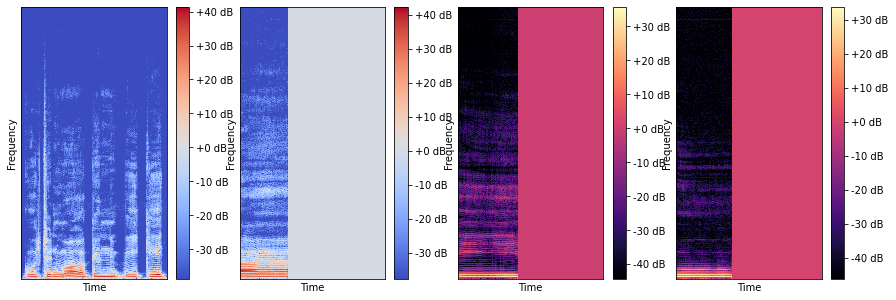

In [16]:
# 4. 데이터 확인하기
for (X_train,a,i,u,Y_train) in train_loader:
    print("X_train : ",X_train.size(),'\na : ',a.size(),'\ni : ',i.size(),'\nu : ',u.size())
    print("Y_train : ",Y_train.size(),'type:',Y_train.type())
    break
    
print(Y_train[0])
plt.figure(figsize=(15,5))
plt.subplot(141)
librosa.display.specshow(X_train[0][0].numpy(), sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')


plt.subplot(142)
librosa.display.specshow(a[0][0].numpy(), sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')

plt.subplot(143)
librosa.display.specshow(i[0][0].numpy(), sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')

plt.subplot(144)
librosa.display.specshow(u[0][0].numpy(), sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')



#plt.xlabel("Time")
#plt.ylabel("Frequency")
#plt.colorbar(format='%+2.0f dB')
#plt.title("Spectrogram (dB)")
#batch: 32 / 3채널 / frame수: 500  /  feature수: 13

X_train :  torch.Size([8, 3, 626, 300]) 
a :  torch.Size([8, 3, 626, 300]) 
i :  torch.Size([8, 3, 626, 300]) 
u :  torch.Size([8, 3, 626, 300])
Y_train :  torch.Size([8]) type: torch.LongTensor
tensor(0)


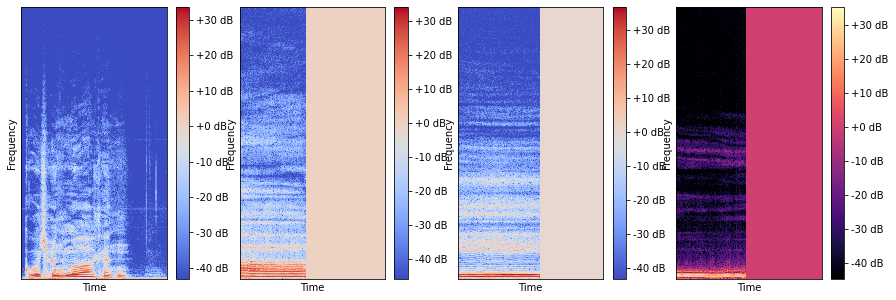

In [17]:
#valiation set 확인
for (X_valid,a_valid,i_valid,u_valid,Y_valid) in validation_loader:
    print("X_train : ",X_valid.size(),'\na : ',a_valid.size(),'\ni : ',i_valid.size(),'\nu : ',u_valid.size())
    print("Y_train : ",Y_valid.size(),'type:',Y_valid.type())
    break
print(Y_valid[0])
plt.figure(figsize=(15,5))
plt.subplot(141)
librosa.display.specshow(X_valid[0][0].numpy(), sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')

plt.subplot(142)
librosa.display.specshow(a_valid[0][0].numpy(), sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')

plt.subplot(143)
librosa.display.specshow(i_valid[0][0].numpy(), sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')

plt.subplot(144)
librosa.display.specshow(u_valid[0][0].numpy(), sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')


#batch: 32 / 3채널 / frame수: 500  /  feature수: 13

X_test :  torch.Size([8, 3, 626, 300]) 
a :  torch.Size([8, 3, 626, 300]) 
i :  torch.Size([8, 3, 626, 300]) 
u :  torch.Size([8, 3, 626, 300])
Y_test :  torch.Size([8]) type: torch.LongTensor
tensor([[[ -9.1242, -12.3221, -18.2020,  ...,  11.2455,  -5.4794,   1.0063],
         [-12.5120, -16.0762, -12.2890,  ...,  18.2339,  18.9862,  19.3285],
         [-20.8110, -28.0435, -18.7605,  ...,  26.7616,  26.6323,  25.9084],
         ...,
         [-42.9204, -42.9204, -42.9204,  ..., -42.9204, -42.9204, -42.9204],
         [-41.6263, -42.9204, -42.9204,  ..., -42.9204, -42.9204, -42.9204],
         [-40.6941, -42.9204, -42.9204,  ..., -42.9204, -42.9204, -42.9204]],

        [[ -9.1242, -12.3221, -18.2020,  ...,  11.2455,  -5.4794,   1.0063],
         [-12.5120, -16.0762, -12.2890,  ...,  18.2339,  18.9862,  19.3285],
         [-20.8110, -28.0435, -18.7605,  ...,  26.7616,  26.6323,  25.9084],
         ...,
         [-42.9204, -42.9204, -42.9204,  ..., -42.9204, -42.9204, -42.9204],
       

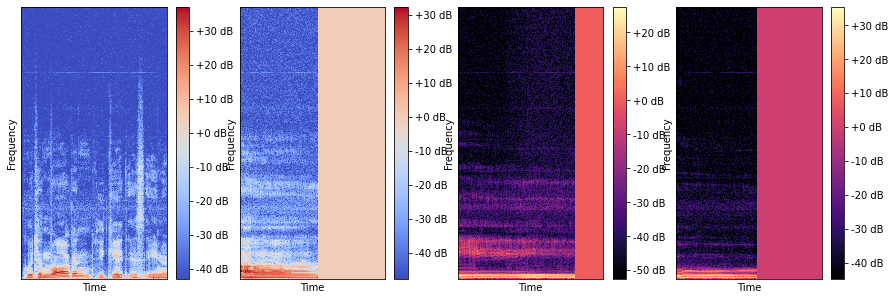

In [18]:
#Test set 확인
for (X_test,a_test,i_test,u_test,Y_test) in test_loader:
    print("X_test : ",X_test.size(),'\na : ',a_test.size(),'\ni : ',i_test.size(),'\nu : ',u_test.size())
    print("Y_test : ",Y_test.size(),'type:',Y_test.type())
    break
    


print(X_test[0])
plt.figure(figsize=(15,5))
plt.subplot(141)
librosa.display.specshow(X_test[0][0].numpy(), sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')

plt.subplot(142)
librosa.display.specshow(a_test[0][0].numpy(), sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')

plt.subplot(143)
librosa.display.specshow(i_test[0][0].numpy(), sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')

plt.subplot(144)
librosa.display.specshow(u_test[0][0].numpy(), sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format='%+2.0f dB')

#batch: 32 / 3채널 / feature수: 128/ frame수: 300   

# RESNET

In [19]:
class resnet18_feature(nn.Module):
    def __init__(self, embedding_dimension=128, pretrained=True):
        super().__init__()
        self.model = models.resnet18(pretrained=pretrained)
        
        # embedding
        input_features_fc_layer = self.model.fc.in_features # fc layer 채널 수 얻기
        self.model.fc = nn.Linear(input_features_fc_layer, embedding_dimension, bias=True) # fc layer 수정
        
    def forward(self, images):
        embedding = self.model(images) # embedding 생성
        return embedding

    
class resnet18_fusion(nn.Module):
    """Model modified.
    The architecture of our model is the same as standard DenseNet121
    except the classifier layer which has an additional sigmoid function.
    """

    def __init__(self, n_class=2):
        super(resnet18_fusion, self).__init__()


        model1 = resnet18_feature()
        self.phrase_model = model1
        in_features = self.phrase_model.model.fc.out_features
        

        model2 = resnet18_feature()
        self.a_model = model2

        model3 = resnet18_feature()
        self.i_model = model3

        model4 = resnet18_feature()
        self.u_model = model4
        

        self.combine = nn.Sequential(
            nn.Linear(in_features * 4, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(256,128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128,64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(64,50),
            nn.BatchNorm1d(50),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(50,n_class)
        )



    def forward(self, phrase,a,i,u):
        phrase_feature = self.phrase_model(phrase)
        a_feature = self.a_model(a)
        i_feature = self.i_model(i)
        u_feature = self.u_model(u)      
        
        #0204 여기부터 수정.

        combine = torch.cat((phrase_feature,
                             a_feature,
                             i_feature,
                             u_feature), 1)
        combine = self.combine(combine)

        return combine

In [20]:
# 모델 
# pretrained


def model_initialize():
    model = resnet18_fusion(n_class=2).cuda()

    return model

model= model_initialize()


In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
print(model)

resnet18_fusion(
  (phrase_model): resnet18_feature(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      

In [22]:
# get the model summary
from torchsummary import summary
#summary(model, input_size=(3, 128, 300), device=DEVICE.type)

In [23]:
#8. 학습
def train(model,train_loader,optimizer, log_interval):
    model.train()
    correct = 0
    train_loss = 0
    for batch_idx,(phrase,a,i,u,label) in enumerate(train_loader):
        phrase = phrase.to(DEVICE)
        a = a.to(DEVICE)
        i = i.to(DEVICE)        
        u = u.to(DEVICE)
        label = label.to(DEVICE)
        
        #데이터들 장비에 할당
        optimizer.zero_grad() # device 에 저장된 gradient 제거
        output = model(phrase,a,i,u) # model로 output을 계산
        loss = criterion(output, label) #loss 계산
        train_loss += loss.item()
        prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
        correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.
        loss.backward() # loss 값을 이용해 gradient를 계산
        optimizer.step() # Gradient 값을 이용해 파라미터 업데이트.
    train_loss/=len(train_loader.dataset)
    train_accuracy = 100. * correct / len(train_loader.dataset)
    return train_loss,train_accuracy


In [24]:
#9. 학습 진행하며, validation 데이터로 모델 성능확인
def evaluate(model,valid_loader):
    model.eval()
    valid_loss = 0
    correct = 0
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for phrase,a,i,u,label in valid_loader:
            phrase = phrase.to(DEVICE)
            a = a.to(DEVICE)
            i = i.to(DEVICE)        
            u = u.to(DEVICE)
            label = label.to(DEVICE)
            output = model(phrase,a,i,u)
            
            valid_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            correct += prediction.eq(label.view_as(prediction)).sum().item()# 아웃풋이 배치 사이즈 32개라서.
            #true.false값을 sum해줌. item
        valid_loss /= len(valid_loader.dataset)
        valid_accuracy = 100. * correct / len(valid_loader.dataset)
        return valid_loss,valid_accuracy


In [25]:
#데이터 로더 제작 함수

def load_data(data_ind):

    train_loader = torch.utils.data.DataLoader(dataset = 
                                               svd_dataset(
                                                   X_train_list,
                                                   classes,
                                                   transform = transforms.ToTensor(),#이걸 composed로 고쳐서 전처리 하도록 수정.
                                                   data_num=data_ind,
                                                   training=True
                                               ),
                                               batch_size = BATCH_SIZE,
                                               shuffle = True,
                                               ) # 순서가 암기되는것을 막기위해.

    validation_loader = torch.utils.data.DataLoader(dataset = 
                                               svd_dataset(
                                                   X_valid_list,
                                                   classes,
                                                   transform = transforms.ToTensor(),
                                                   data_num=data_ind,
                                                   training=False
                                               ),
                                               batch_size = BATCH_SIZE,
                                               shuffle = True,) 
    return train_loader,validation_loader



In [ ]:
#10. 학습 및 평가.
# resnet34 pretrained true
# kfold 적용

train_accs = []
valid_accs = []

for data_ind in range(1,6):

    check_path = '../../checkpoint/checkpoint_spectro_resnet18_true_ros_'+str(data_ind)+'_300_fusion.pt'
    print(check_path)
    early_stopping = EarlyStopping(patience = 5, verbose = True, path=check_path)
    train_loader,validation_loader = load_data(data_ind-1)
    
    best_train_acc=0 # accuracy 기록용
    best_valid_acc=0
    
    model=model_initialize()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
    
    
    print("[{} 교차검증] 학습 시작\n ----- ".format(data_ind))
    for Epoch in range(1,EPOCHS+1):
        train_loss,train_accuracy=train(model,train_loader,optimizer,log_interval=31)
        valid_loss,valid_accuracy = evaluate(model, validation_loader)


        print("\n[EPOCH:{}]\t Train Loss:{:.4f}\t Train Acc:{:.2f} %  | \tValid Loss:{:.4f} \tValid Acc: {:.2f} %\n".
              format(Epoch,train_loss,train_accuracy,valid_loss,valid_accuracy))
        

        early_stopping(valid_loss, model)
        if -early_stopping.best_score == valid_loss:
            best_train_acc, best_valid_acc = train_accuracy,valid_accuracy
        
        if early_stopping.early_stop:
                train_accs.append(best_train_acc)
                valid_accs.append(best_valid_acc)
                print("[{} 교차검증] Early stopping".format(data_ind))
                break

        if Epoch==EPOCHS:
            #만약 early stop 없이 40 epoch라서 중지 된 경우.
            train_accs.append(best_train_acc)
            valid_accs.append(best_valid_acc)
            
            


../../checkpoint/checkpoint_spectro_resnet18_true_ros_1_300_fusion.pt
[1 교차검증] 학습 시작
 ----- 

[EPOCH:1]	 Train Loss:0.0933	 Train Acc:50.52 %  | 	Valid Loss:0.0899 	Valid Acc: 42.32 %

Validation loss decreased (inf --> 0.089878).  Saving model ...

[EPOCH:2]	 Train Loss:0.0875	 Train Acc:56.49 %  | 	Valid Loss:0.0855 	Valid Acc: 53.58 %

Validation loss decreased (0.089878 --> 0.085454).  Saving model ...

[EPOCH:3]	 Train Loss:0.0830	 Train Acc:60.22 %  | 	Valid Loss:0.0731 	Valid Acc: 71.33 %

Validation loss decreased (0.085454 --> 0.073135).  Saving model ...

[EPOCH:4]	 Train Loss:0.0785	 Train Acc:64.94 %  | 	Valid Loss:0.0721 	Valid Acc: 70.99 %

Validation loss decreased (0.073135 --> 0.072106).  Saving model ...

[EPOCH:5]	 Train Loss:0.0734	 Train Acc:71.69 %  | 	Valid Loss:0.0683 	Valid Acc: 75.43 %

Validation loss decreased (0.072106 --> 0.068341).  Saving model ...

[EPOCH:6]	 Train Loss:0.0664	 Train Acc:73.72 %  | 	Valid Loss:0.0695 	Valid Acc: 73.38 %

EarlyStopping c


[EPOCH:7]	 Train Loss:0.0496	 Train Acc:84.34 %  | 	Valid Loss:0.0581 	Valid Acc: 82.53 %

Validation loss decreased (0.060077 --> 0.058128).  Saving model ...

[EPOCH:8]	 Train Loss:0.0466	 Train Acc:85.32 %  | 	Valid Loss:0.0534 	Valid Acc: 84.59 %

Validation loss decreased (0.058128 --> 0.053398).  Saving model ...

[EPOCH:9]	 Train Loss:0.0437	 Train Acc:87.42 %  | 	Valid Loss:0.0609 	Valid Acc: 75.00 %

EarlyStopping counter: 1 out of 5

[EPOCH:10]	 Train Loss:0.0359	 Train Acc:90.50 %  | 	Valid Loss:0.0554 	Valid Acc: 81.85 %

EarlyStopping counter: 2 out of 5

[EPOCH:11]	 Train Loss:0.0327	 Train Acc:91.81 %  | 	Valid Loss:0.0573 	Valid Acc: 77.74 %

EarlyStopping counter: 3 out of 5

[EPOCH:12]	 Train Loss:0.0327	 Train Acc:91.74 %  | 	Valid Loss:0.0507 	Valid Acc: 84.25 %

Validation loss decreased (0.053398 --> 0.050665).  Saving model ...

[EPOCH:13]	 Train Loss:0.0270	 Train Acc:93.18 %  | 	Valid Loss:0.0491 	Valid Acc: 81.51 %

Validation loss decreased (0.050665 --> 0.0

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "D:\miniconda3\envs\local_torch\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Desktop\AppData\Local\Temp/ipykernel_13024/1054678336.py", line 25, in <module>
    train_loss,train_accuracy=train(model,train_loader,optimizer,log_interval=31)
  File "C:\Users\Desktop\AppData\Local\Temp/ipykernel_13024/2447579562.py", line 15, in train
    output = model(phrase,a,i,u) # model로 output을 계산
  File "D:\miniconda3\envs\local_torch\lib\site-packages\torch\nn\modules\module.py", line 1102, in _call_impl
    return forward_call(*input, **kwargs)
  File "C:\Users\Desktop\AppData\Local\Temp/ipykernel_13024/870735884.py", line 64, in forward
    a_feature = self.a_model(a)
  File "D:\miniconda3\envs\local_torch\lib\site-packages\torch\nn\modules\module.py", line 1102, in _call_impl
    return forward_call(*input, **kwargs)
  File "C:\Users\Desktop\AppData\Loca

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "D:\miniconda3\envs\local_torch\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Desktop\AppData\Local\Temp/ipykernel_13024/1054678336.py", line 25, in <module>
    train_loss,train_accuracy=train(model,train_loader,optimizer,log_interval=31)
  File "C:\Users\Desktop\AppData\Local\Temp/ipykernel_13024/2447579562.py", line 15, in train
    output = model(phrase,a,i,u) # model로 output을 계산
  File "D:\miniconda3\envs\local_torch\lib\site-packages\torch\nn\modules\module.py", line 1102, in _call_impl
    return forward_call(*input, **kwargs)
  File "C:\Users\Desktop\AppData\Local\Temp/ipykernel_13024/870735884.py", line 64, in forward
    a_feature = self.a_model(a)
  File "D:\miniconda3\envs\local_torch\lib\site-packages\torch\nn\modules\module.py", line 1102, in _call_impl
    return forward_call(*input, **kwargs)
  File "C:\Users\Desktop\AppData\Loca

# Model 결과 확인

In [ ]:
sum_valid=0
for data_ind in range(5):
    print("[{} 교차검증] train ACC : {:.4f} |\t valid ACC: {:.4f} ".format(data_ind+1,train_accs[data_ind],valid_accs[data_ind] ))
    sum_valid+=valid_accs[data_ind]
    
print("평균 검증 정확도",sum_valid/5,"%")

# Model Test

- test set
- confusion matrix

In [ ]:
#confusion matrix 계산
#test set 계산.
def test_evaluate(model,test_loader):
    model.eval()
    test_loss = 0
    predictions = []
    answers = []
    #no_grad : 그래디언트 값 계산 막기.
    with torch.no_grad():
        for image, label in test_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            test_loss += criterion(output, label).item()
            prediction = output.max(1,keepdim=True)[1] # 가장 확률이 높은 class 1개를 가져온다.그리고 인덱스만
            answers +=label
            predictions +=prediction
            
        return predictions,answers,test_loss
            

In [ ]:
# Confusion matrix (resnet18)
# kfold의 confusion matrix는 계산 방법이 다르다.
# 모델을 각각 불러와서 test set을 평가한다.

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

cf = np.zeros((2,2))
cf_list = []
average_accuracy = 0
average_fscore = 0

for data_ind in range(1,6):

    check_path = '../../checkpoint/checkpoint_spectro_resnet18_true_ros_'+str(data_ind)+'_300_fusion.pt'
    model.load_state_dict(torch.load(check_path))

    predictions,answers,test_loss = test_evaluate(model, test_loader)
    predictions=[ dat.cpu().numpy() for dat in predictions]
    answers=[ dat.cpu().numpy() for dat in answers]

    
    cf = confusion_matrix(answers, predictions)
    cf_list.append(cf)
    
    acc = (cf[0,0]+cf[1,1])/(cf[0,0]+cf[0,1]+cf[1,0]+cf[1,1])
    average_accuracy+=acc
    precision=cf[0,0]/(cf[0,0]+cf[1,0])
    recall=cf[0,0]/(cf[0,0]+cf[0,1])
    #fscore=2*precision*recall/(precision+recall)
    
    #fscroe macro추가
    fscore = f1_score(answers,predictions,average='macro')
    average_fscore+=fscore
    
    print('{}번 모델'.format(data_ind))
    print("Accuracy : {:.4f}% ".format(acc*100))
    print("Precision (pathology 예측한 것중 맞는 것) : {:.4f}".format(precision))
    print("recall (실제 pathology 중  예측이 맞는 것) : {:.4f}".format(recall))
    print("f score : {:.4f} ".format(fscore))
    print(cf)
    print("-----")

print("평균 acc : {:.4f}".format(average_accuracy/5))
print("평균 f1score : {:.4f}".format(average_fscore/5))




# 기타

In [32]:
#크기 알아보기
#일반 CNN

m = nn.MaxPool2d(2, stride=2)
#m = nn.MaxPool2d((3, 2), stride=(2, 1))
input = torch.randn(32, 1, 500, 13)
print(input.size())
output = m(input)
print(output.size())
output = m(output)
print(output.size())

torch.Size([32, 1, 500, 13])
torch.Size([32, 1, 250, 6])
torch.Size([32, 1, 125, 3])


In [33]:
#크기 알아보기
#주파수 영역 CNN

input = torch.randn(32, 1, 500, 13)
m=nn.Conv2d(
            in_channels = 1,# 채널이 1개
            out_channels = 32,# FeatureMap 수,커널 수
            kernel_size = (1,13),#1x13  no padding
        )
output=m(input)
print(output.size())
m=nn.Conv2d(
            in_channels = 32,# 채널이 1개
            out_channels = 64,# FeatureMap 수,커널 수
            kernel_size = (27,1),#9 x 1 no padding
        )
output=m(output)
print(output.size())


torch.Size([32, 32, 500, 1])
torch.Size([32, 64, 474, 1])


In [34]:
input = torch.randn(500, 13)

out=torch.stack([input,input,input])
out.size()

torch.Size([3, 500, 13])